# Trend and growth rate analysis of CO2 data

This is a classis example of "seasonal-trend" decomposition, and an analysis of this data set is presented in the STL paper (up until about 1990).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
from scipy.signal import find_peaks

In [3]:
%matplotlib inline

import matplotlib
sns.set_context('paper')
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# %matplotlib notebook

In [4]:
import sys
sys.path.append('..')
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SmoothFirstDifference, \
    SparseSecondDiffConvex, LinearTrend, ApproxPeriodic
SOLVER = 'MOSEK'

from statsmodels.tsa.seasonal import STL

In [5]:
def rmse(actual, predicted):
    r = actual - predicted
    return np.sqrt(np.average(np.power(r, 2)))

In [6]:
data = pd.read_csv('data/co2_weekly_mlo.csv', header=47, na_values=[-999.99])

In [7]:
data['log_co2'] = np.log10(data['average'])

In [8]:
data.index = pd.to_datetime(data[['year', 'month', 'day']])

In [9]:
plt.figure(figsize=(6, 3))
plt.plot(data.index, data['average'], label='weekly average CO$_2$')
plt.legend(loc=4)
plt.xlabel('year')
plt.ylabel('parts per million (ppm)')
plt.title('atmospheric CO$_2$ at Mauna Loa observatory')
plt.tight_layout()
fig = plt.gcf()
plt.show()
fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/co2-data.pgf')

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


## Part 1: Comparison to STL

In [10]:
stl = STL(data.average.interpolate(inplace=False), period=52)
res = stl.fit()

In [11]:
prob_stl = Problem(data.average.interpolate(inplace=False).values, [GaussNoise()] * 3)
prob_stl.estimates = np.c_[res.resid, res.trend, res.seasonal].T
prob_stl.use_set = np.ones(len(data), dtype=bool)
fig = prob_stl.plot_decomposition(label='STL', x_series=data.index, figsize=(6.5, 5))
ax = fig.axes
ax[0].legend(['STL residual'])
ax[1].legend(['STL trend'])
ax[2].legend(['STL seasonal'])
plt.tight_layout()
plt.show()
fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/co2-stl.pgf')

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


In [12]:
y = data['average'].values

c1 = GaussNoise()
c2 = SmoothSecondDifference(weight=1e4)
# c3 = SmoothSecondDifference(weight=0, period=52)
c3 =  ApproxPeriodic(weight=1e0, period=52)

components = [c1, c2, c3]
problem0 = Problem(y, components)

In [13]:
val0 = problem0.holdout_validation(seed=1, solver=SOLVER)
print('Model 0 error: {:.1e}'.format(val0))

Model 0 error: 9.9e+01


In [14]:
problem0.decompose(solver=SOLVER)
fig = problem0.plot_decomposition(label='OSD', x_series=data.index, figsize=(6.5, 5))
ax = fig.axes
ax[0].legend(['OSD residual'])
ax[1].legend(['OSD trend'])
ax[2].legend(['OSD seasonal'])

plt.tight_layout()
plt.show()
fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-Paper/figs/co2-osd.pgf')

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


RMSE: 7.16e-02


<IPython.core.display.Javascript object>


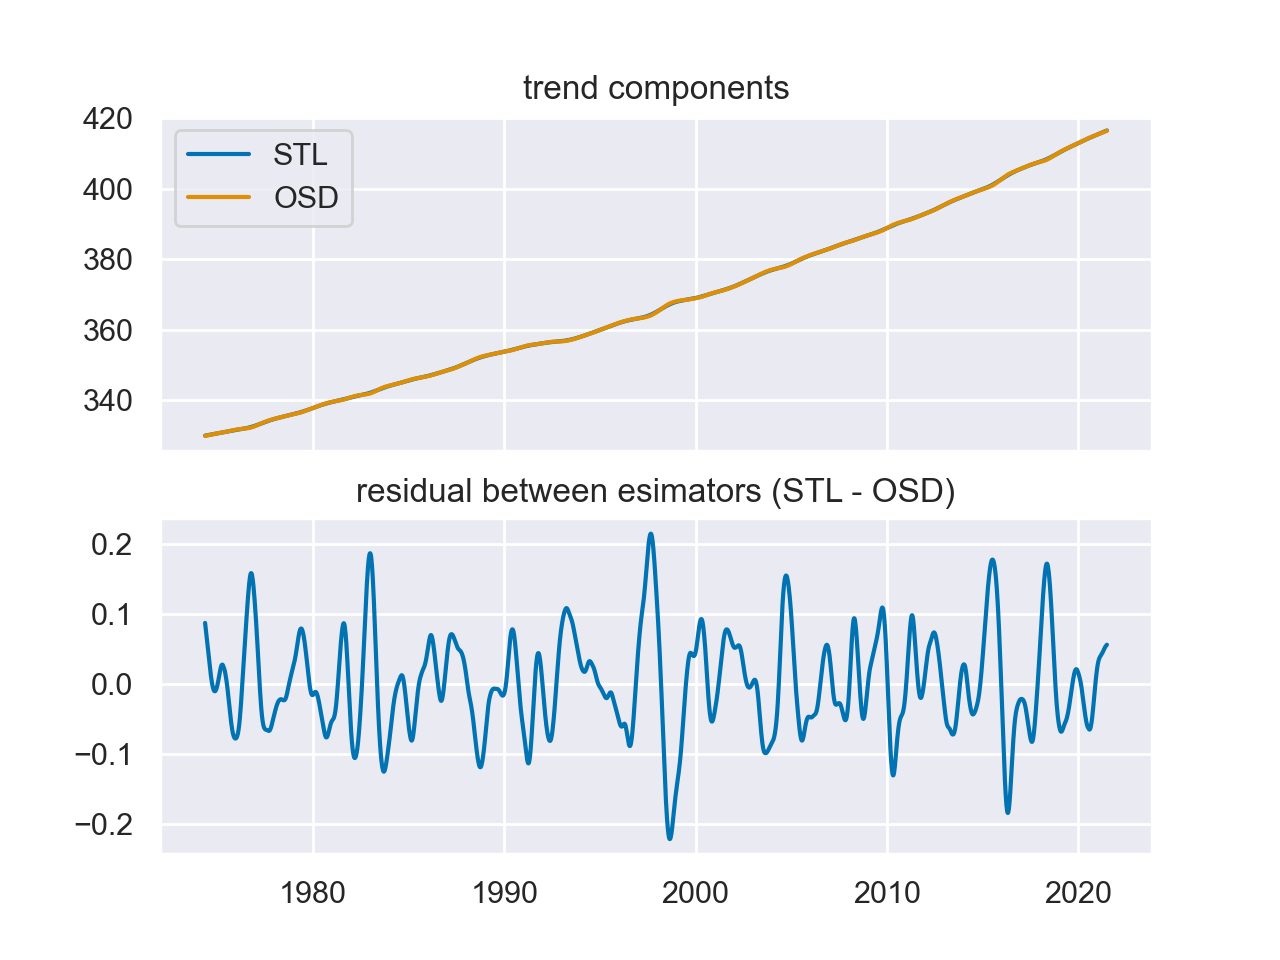

In [53]:
print('RMSE: {:.2e}'.format(rmse(res.trend.values, problem0.estimates[1])))
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(res.trend.index, res.trend.values, label='STL')
ax[0].plot(res.trend.index, problem0.estimates[1], label='OSD')
ax[0].set_title('trend components')
ax[0].legend()
ax[1].plot(res.trend.index, res.trend.values-problem0.estimates[1])
ax[1].set_title('residual between esimators (STL - OSD)');

RMSE: 8.51e-02


<IPython.core.display.Javascript object>


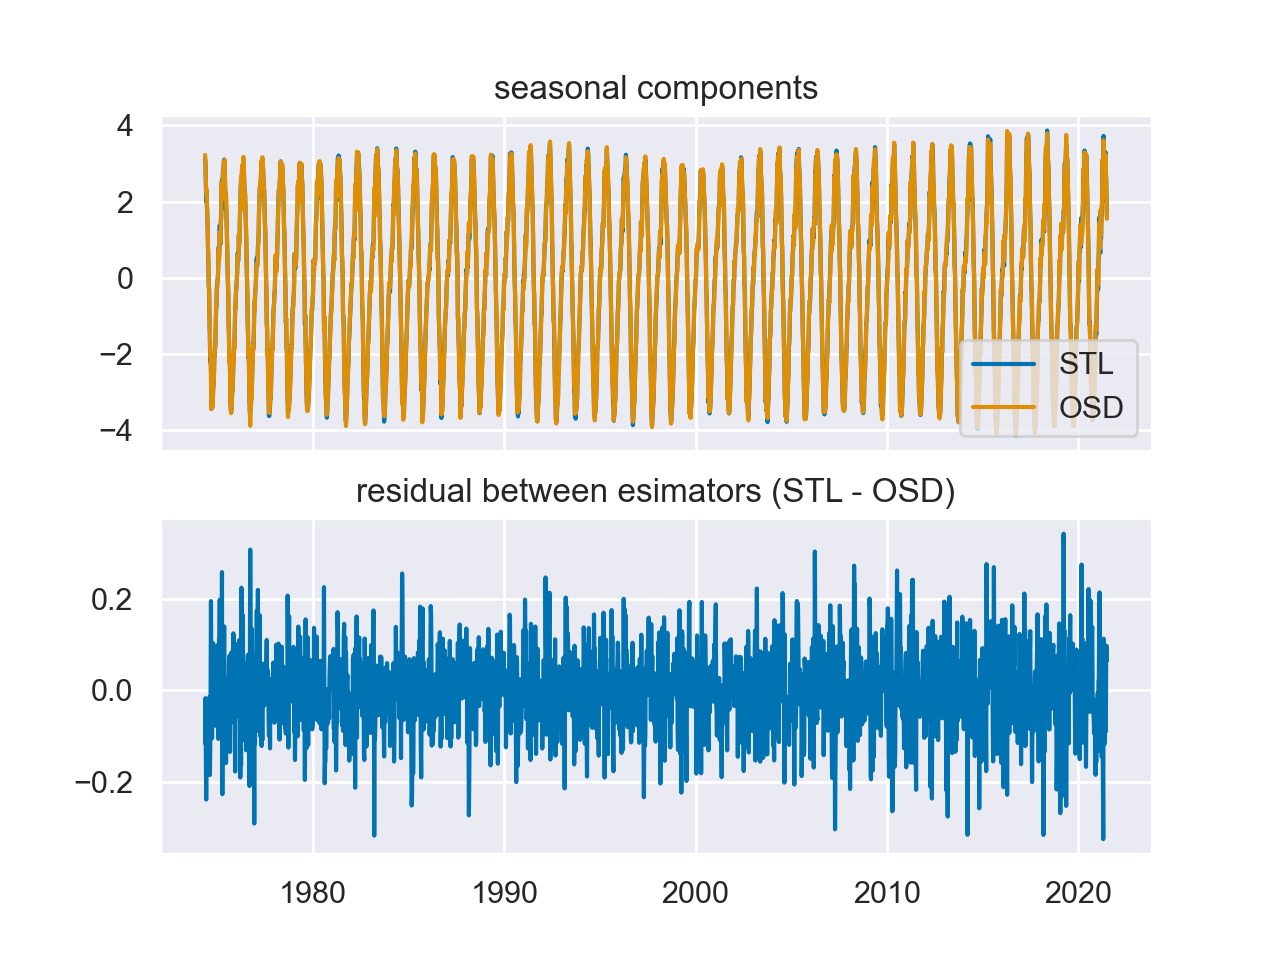

In [45]:
print('RMSE: {:.2e}'.format(rmse(res.seasonal.values, problem0.estimates[2])))
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(res.seasonal.index, res.seasonal.values, label='STL')
ax[0].plot(res.seasonal.index, problem0.estimates[2], label='OSD')
ax[0].set_title('seasonal components')
ax[0].legend()
ax[1].plot(res.seasonal.index, res.seasonal.values-problem0.estimates[2])
ax[1].set_title('residual between esimators (STL - OSD)');

RMSE: 1.27e-01


<IPython.core.display.Javascript object>


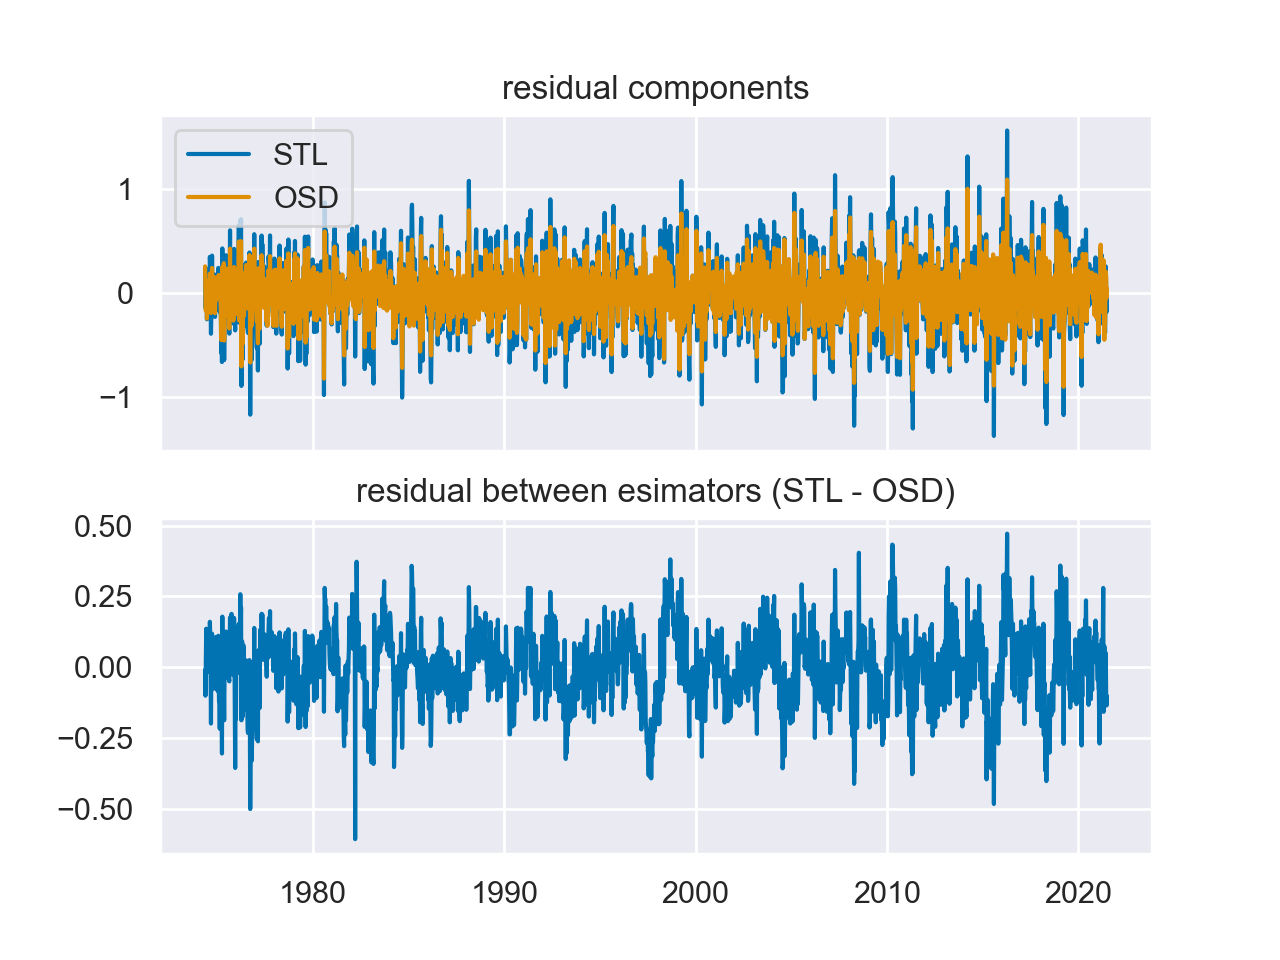

In [36]:
print('RMSE: {:.2e}'.format(rmse(res.resid.values, problem0.estimates[0])))
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(res.resid.index, res.resid.values, label='STL')
ax[0].plot(res.resid.index, problem0.estimates[0], label='OSD')
ax[0].set_title('residual components')
ax[0].legend()
ax[1].plot(res.resid.index, res.resid.values-problem0.estimates[0])
ax[1].set_title('residual between esimators (STL - OSD)');

## Part 2: Single growth rate versus multiple growth rates

Rather than having a generic smooth trend, try to analyze the growth rate of C02 in the atmosphere. In OSD, it is straightford to the replace the trend component in the model with a new component class. 

For this part, we take the log of the measured data, so that linear trends correspond to exponential growth curves. Then we fit a simple linear trend model, corresponding to finding an exponential growth rate that describes the entire data set. Finally we fit a piecewise linear trend model with sparse breakpoints, using the convex $\ell_1$ heuristic. We use holdout validation to show that the PWL model is a better description of the data, and we find that there are distinct growth rate periods.

In [22]:
y = data['log_co2'].values

c1 = GaussNoise()
c2 = LinearTrend()
c3 = SmoothSecondDifference(theta=0, period=52)

components = [c1, c2, c3]
problem1 = Problem(y, components)

c1 = GaussNoise()
c2 = SparseSecondDiffConvex(theta=5e1)
c3 = SmoothSecondDifference(theta=1e2, period=52)

components = [c1, c2, c3]
problem2 = Problem(y, components)

In [23]:
val1 = problem1.holdout_validation(seed=1, solver=SOLVER)
val2 = problem2.holdout_validation(seed=1, solver=SOLVER)
print('Model 1 error: {:.1e}\nModel 2 error: {:.1e}'.format(val1, val2))

Model 1 error: 2.1e-03
Model 2 error: 3.7e-04


In [24]:
problem1.decompose(solver=SOLVER)
problem2.decompose(solver=SOLVER)

<IPython.core.display.Javascript object>


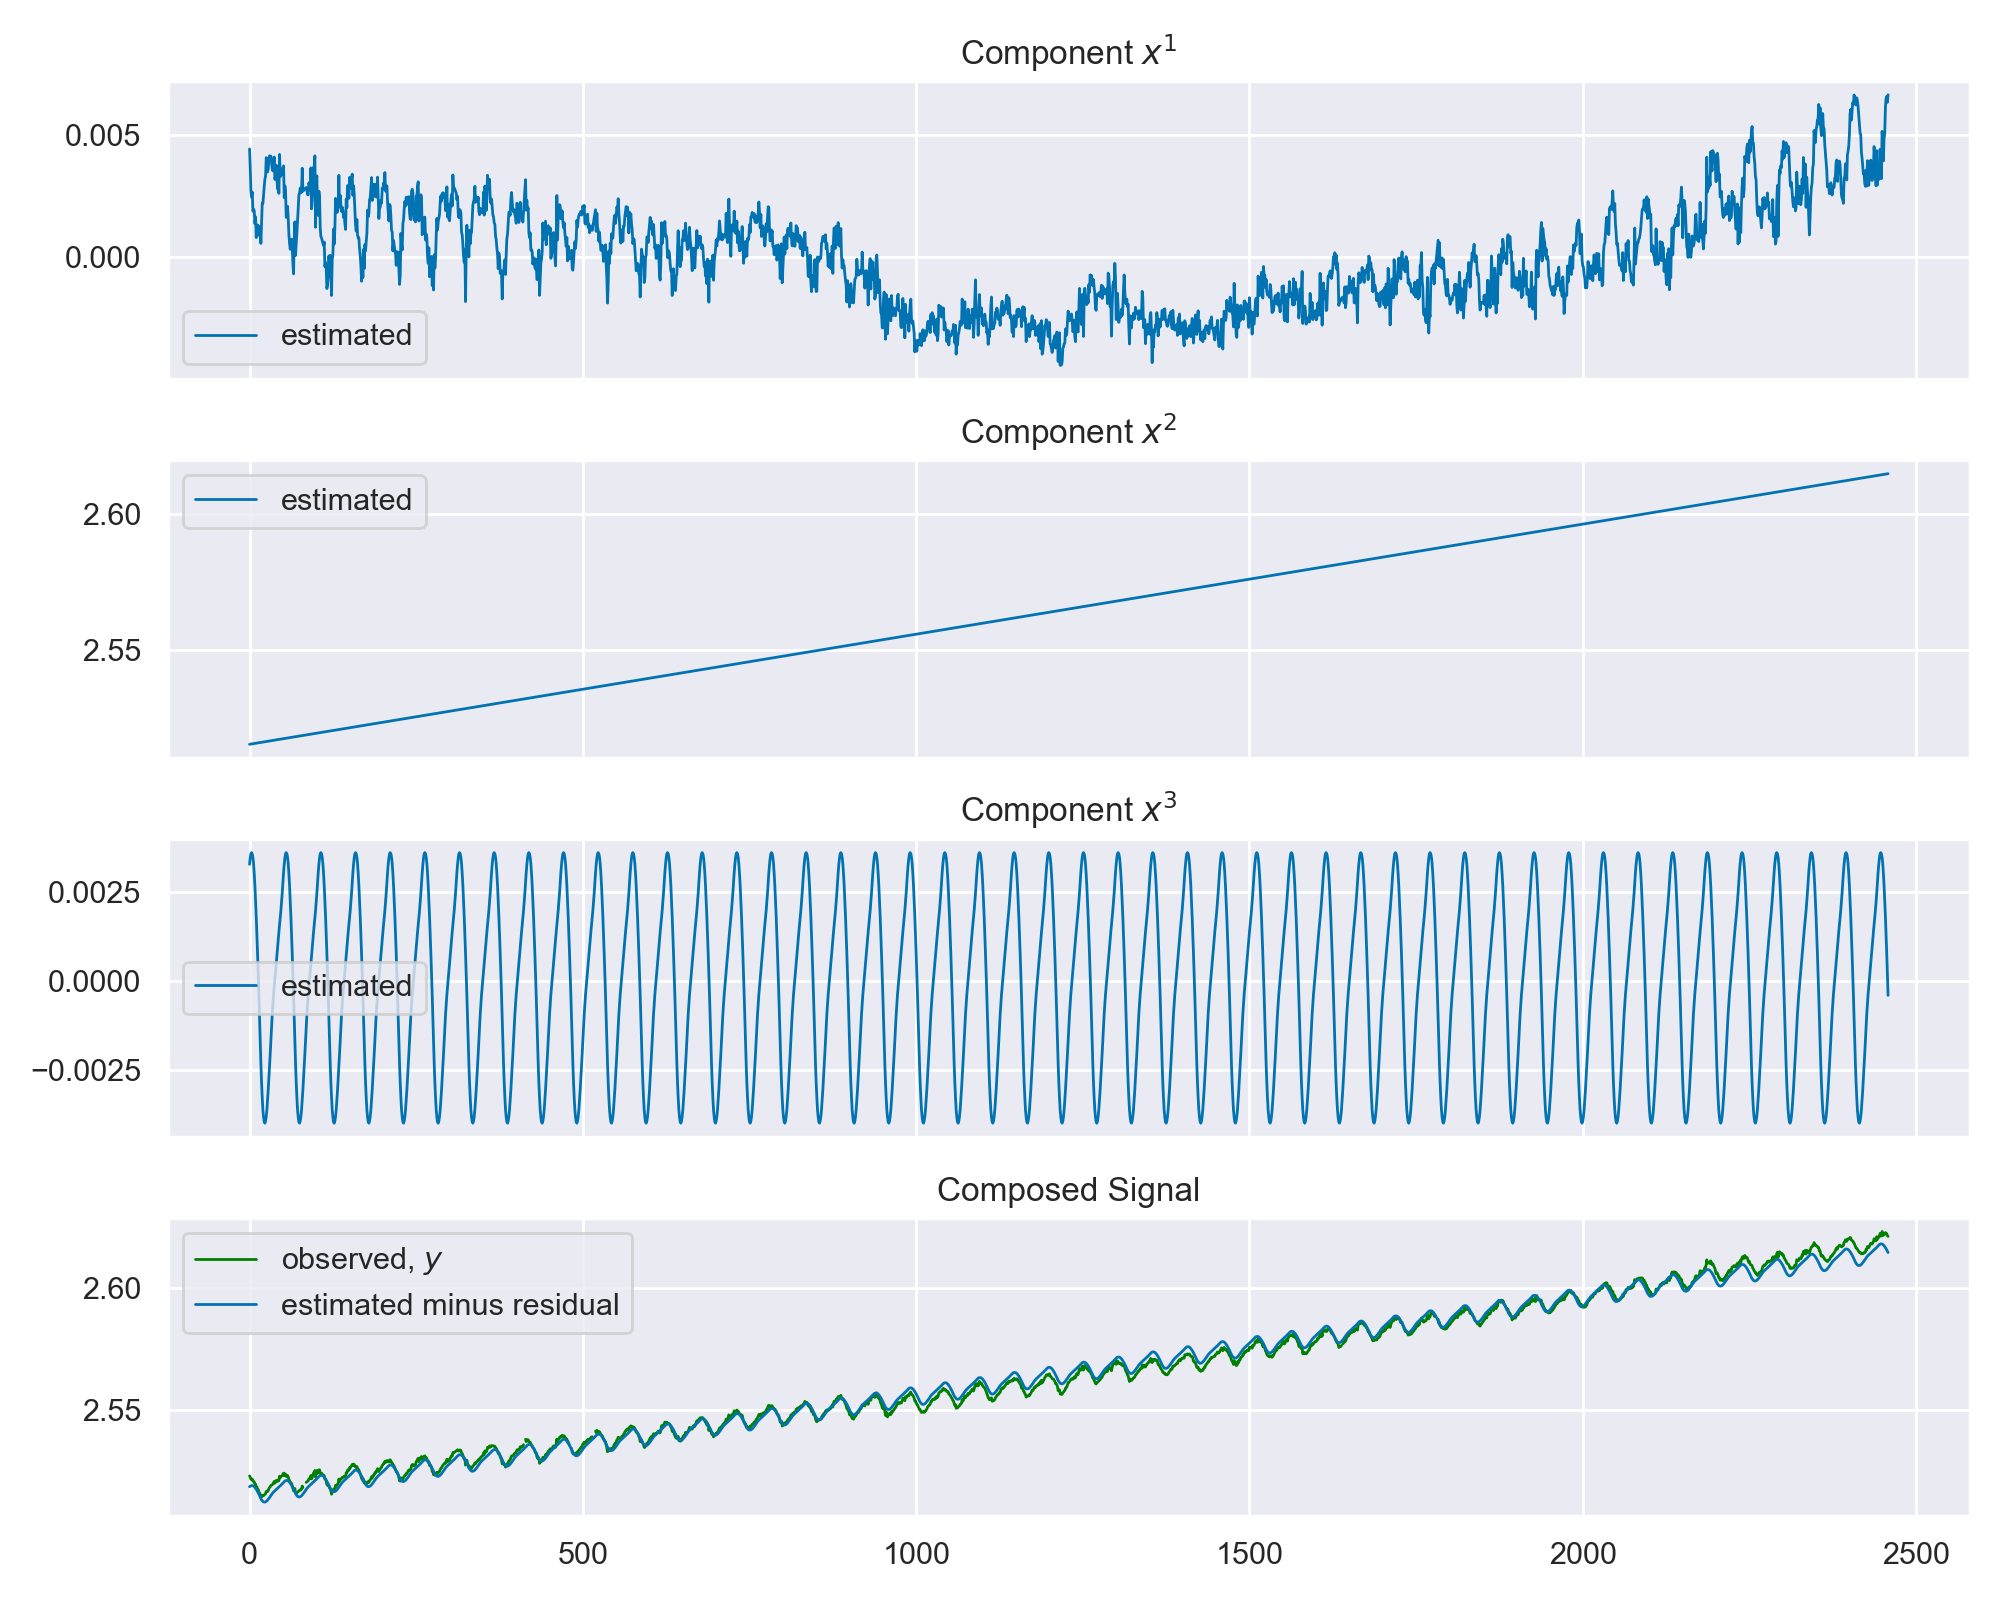

In [25]:
problem1.plot_decomposition();

<IPython.core.display.Javascript object>


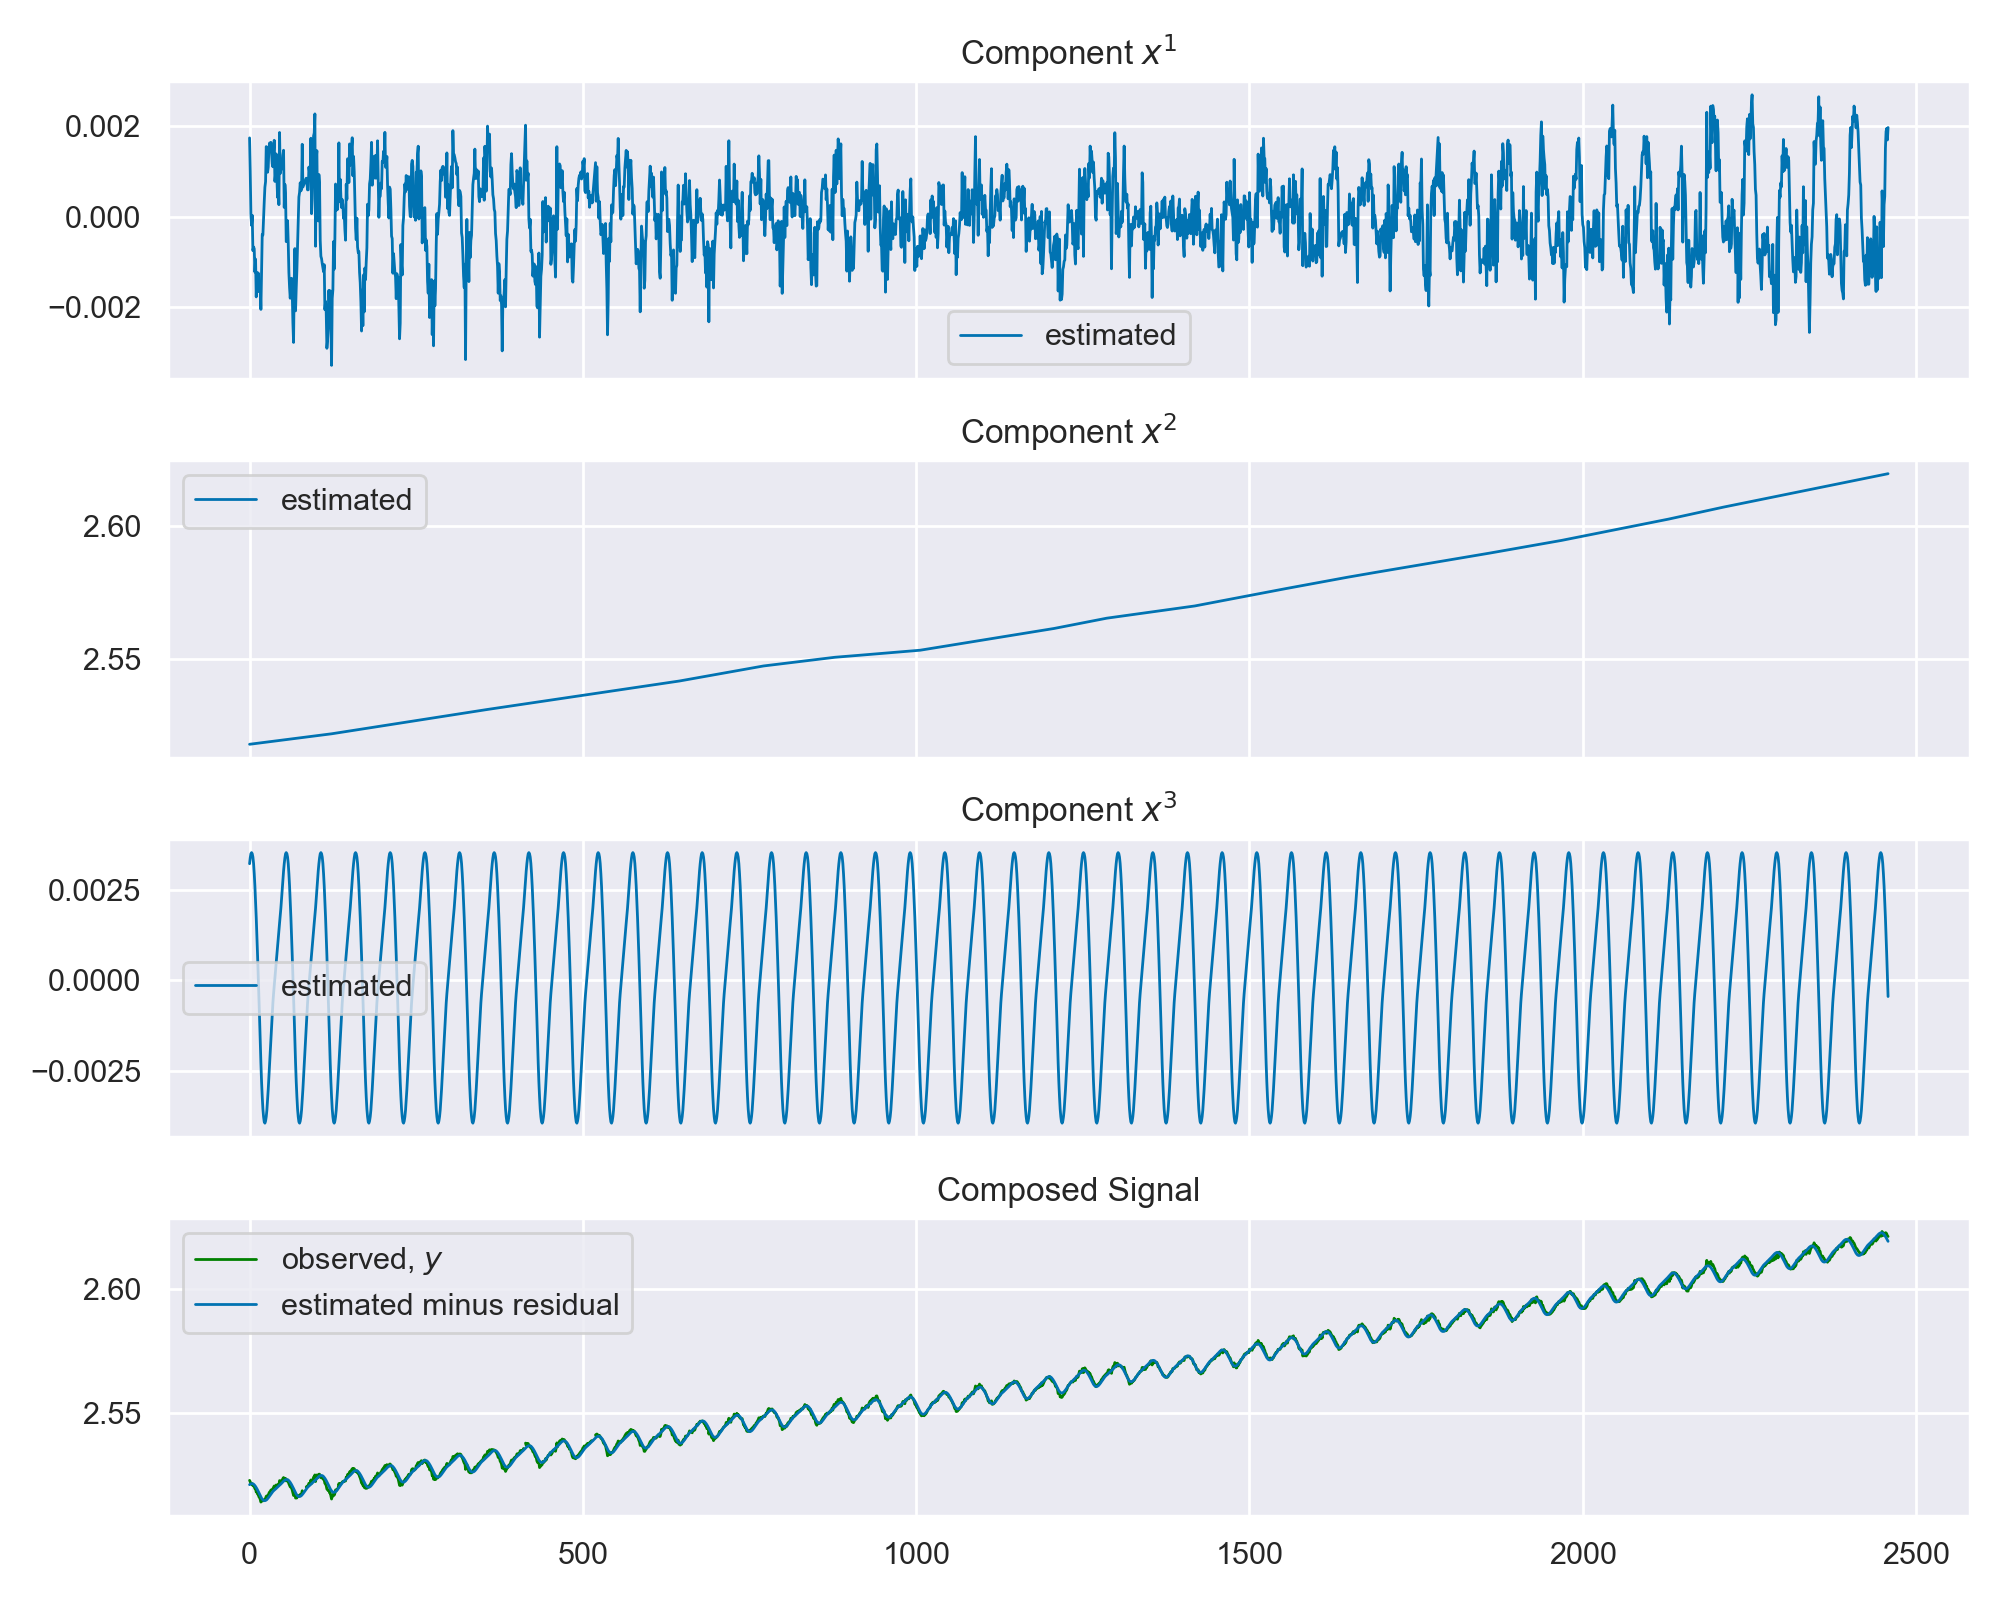

In [26]:
problem2.plot_decomposition();

In [27]:
# Calculate rate found through first model and breakpoints found in second model

single_rate = np.average(np.diff(problem1.estimates[1]))
peaks, heights = find_peaks(np.abs(np.diff(problem2.estimates[1], n=2)) 
                            / np.max(np.abs(np.diff(problem2.estimates[1], n=2))), 
                            height=0.02, distance=10)

<IPython.core.display.Javascript object>


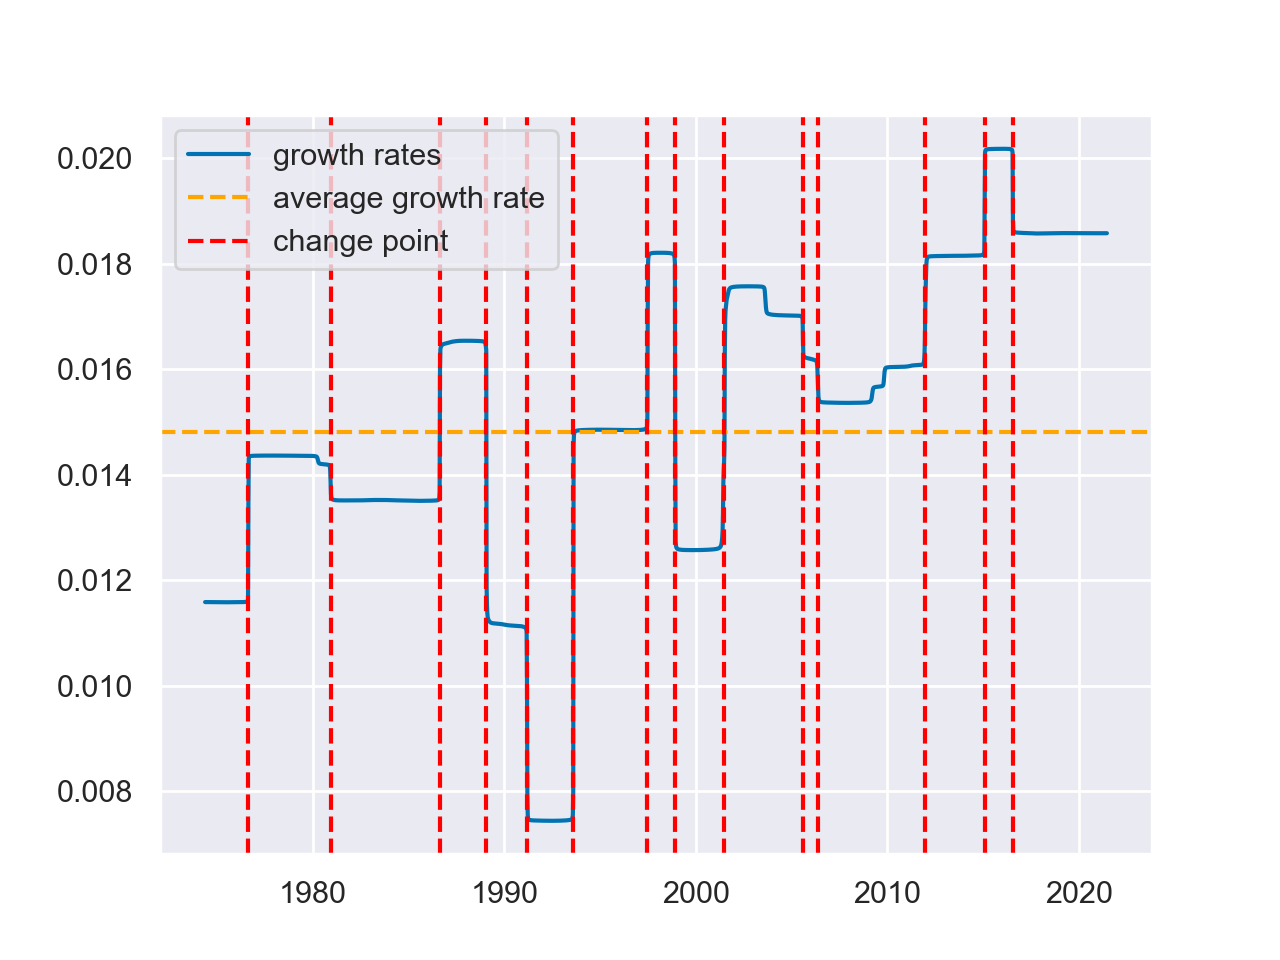

In [28]:
plt.figure()
scale = 1. / 365
plt.plot(data['decimal'][:-1], np.diff(problem2.estimates[1] / scale, n=1), label='growth rates')
plt.axhline(single_rate / scale, color='orange', ls='--', label='average growth rate')
for ix, p in enumerate(peaks):
    l = data['decimal'][p]
    if ix == 0:
        plt.axvline(l, color='red', ls='--', label='change point')
    else:
        plt.axvline(l, color='red', ls='--')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


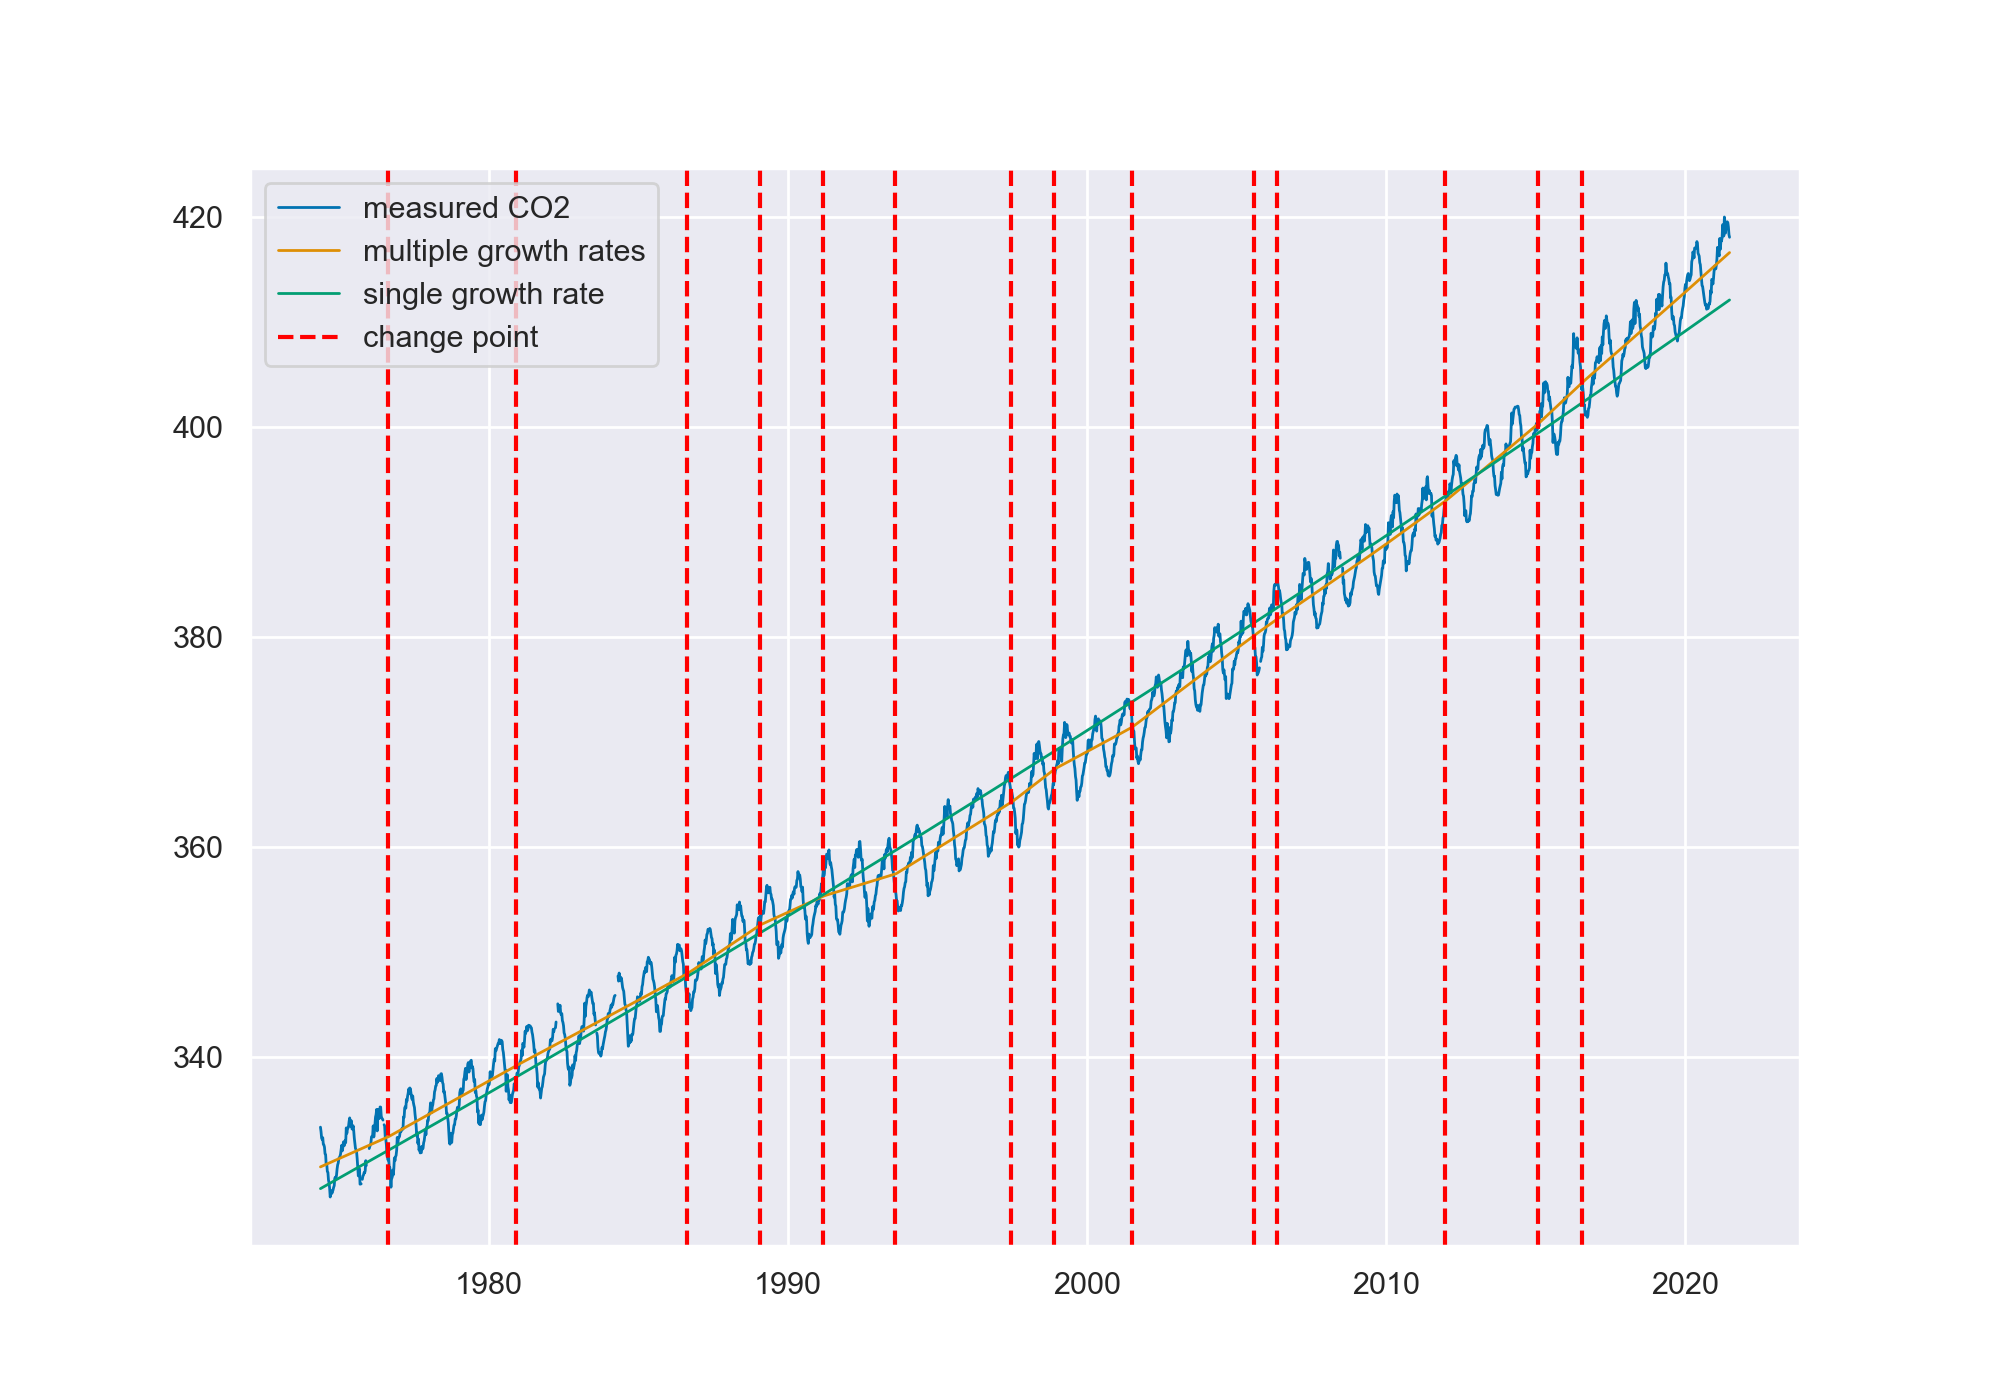

In [29]:

plt.figure(figsize=(10,7))
plt.plot(data['decimal'], 10**y, label='measured CO2', linewidth=1)
plt.plot(data['decimal'], 10**problem2.estimates[1], label='multiple growth rates', linewidth=1)
plt.plot(data['decimal'], 10**(problem1.estimates[1]), label='single growth rate', linewidth=1)
# for l in np.arange(T)[np.r_[[False], np.abs(1e6 * np.diff(x[1].value, n=2)) >= 0.1, [False]]]:
#     plt.axvline(l)
for ix, p in enumerate(peaks):
    l = data['decimal'][p]
    if ix == 0:
        plt.axvline(l, color='red', ls='--', label='change point')
    else:
        plt.axvline(l, color='red', ls='--')
plt.legend()
plt.show()